In [1]:
# !pip install pyspark[sql] findspark --user

import sys

import findspark
findspark.init()
findspark.find()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *


spark = SparkSession.builder \
    .appName("Spark Streaming") \
    .config("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "512mb") \
    .getOrCreate()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-18 16:23:31,351 WARN cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


# Realtime Join

Как выяснилось, Join двух потоков отличается от Join операции над статическими данными. Ниже несколько нюансов join-a в реальном времени, которые надо как-то разрешить. Не все данные известны, они приходят в реальном времени.

## Event Time
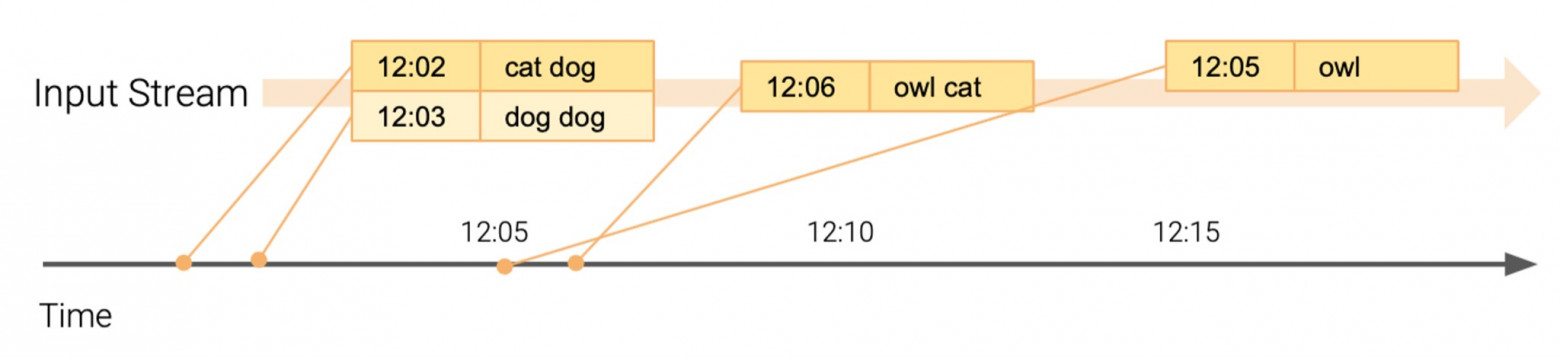
Именно Event time позволит восстановить последовательность событий и моменты времени, к которым они относятся.

## Watermark
Watermark – это то время, после которого все события потока должны храниться в стейте и которое обновляется в конце обработки каждого микробатча. Watermark позволяет ограничить количество хранимых событий.
Вычисляется Watermark так:

1. берём максимальное (минимальное или среднее, есть вариации) время события в стейте (Event time, естественно);
2. вычитаем watermarkDelay – некоторое значение типа timedelta, которое мы задали в коде.

## Join Condition

In [ ]:
s1 = input_stream1.alias("s1")
s2 = input_stream2.alias("s2")

s1.join(
s2, on="""
s1.word=s2.word
and s1.event_time <= s2.event_time + interval '5 seconds'
and s1.event_time >= s2.event_time - interval '30 seconds'
""")

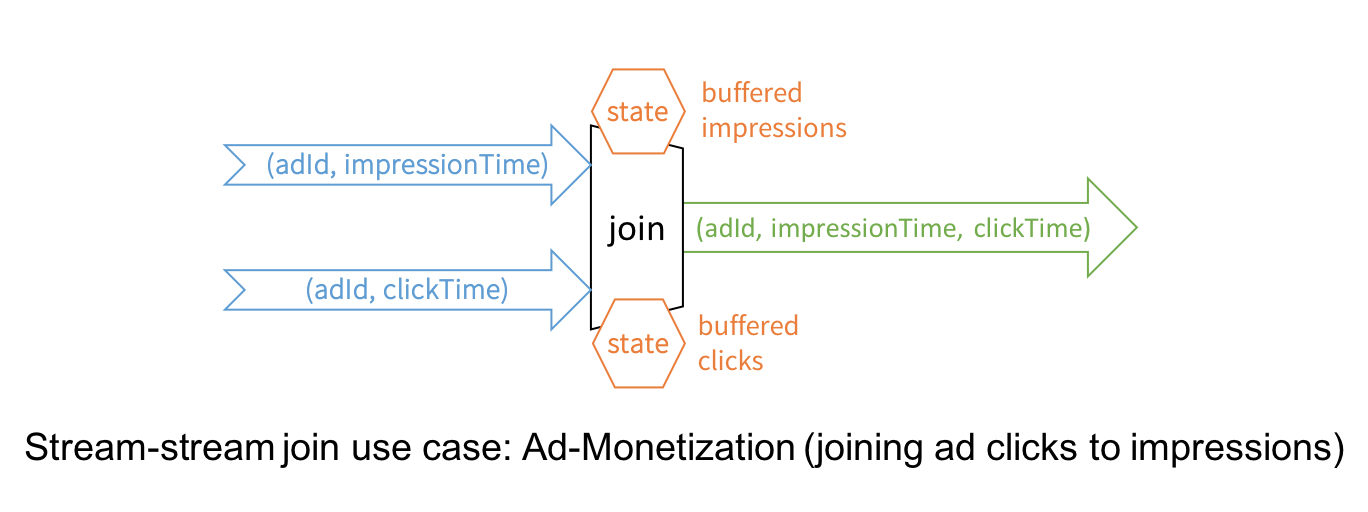
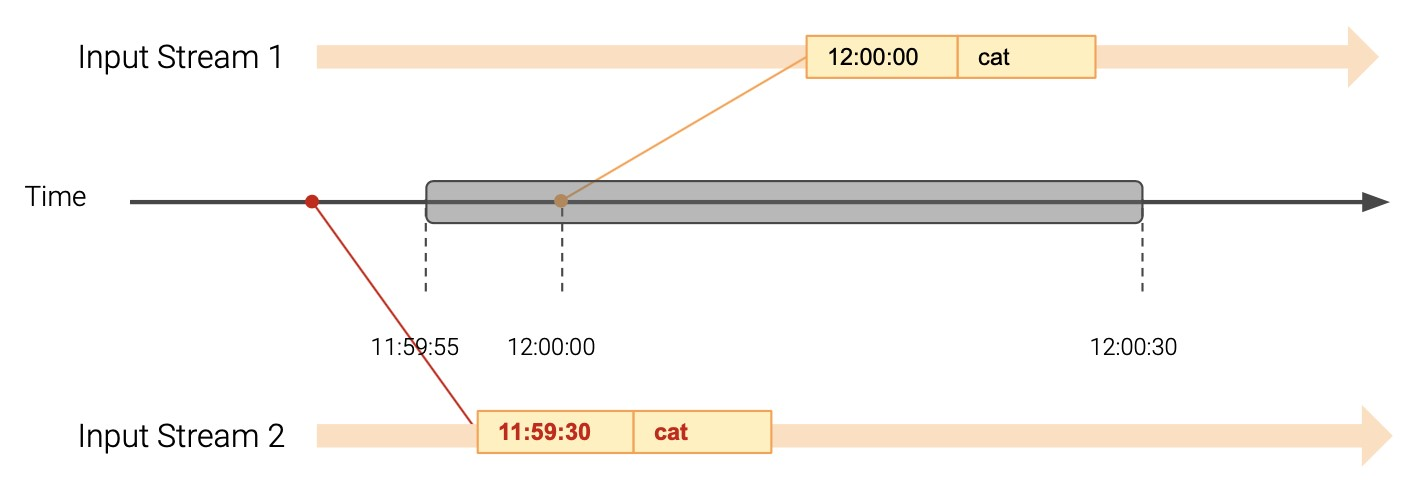

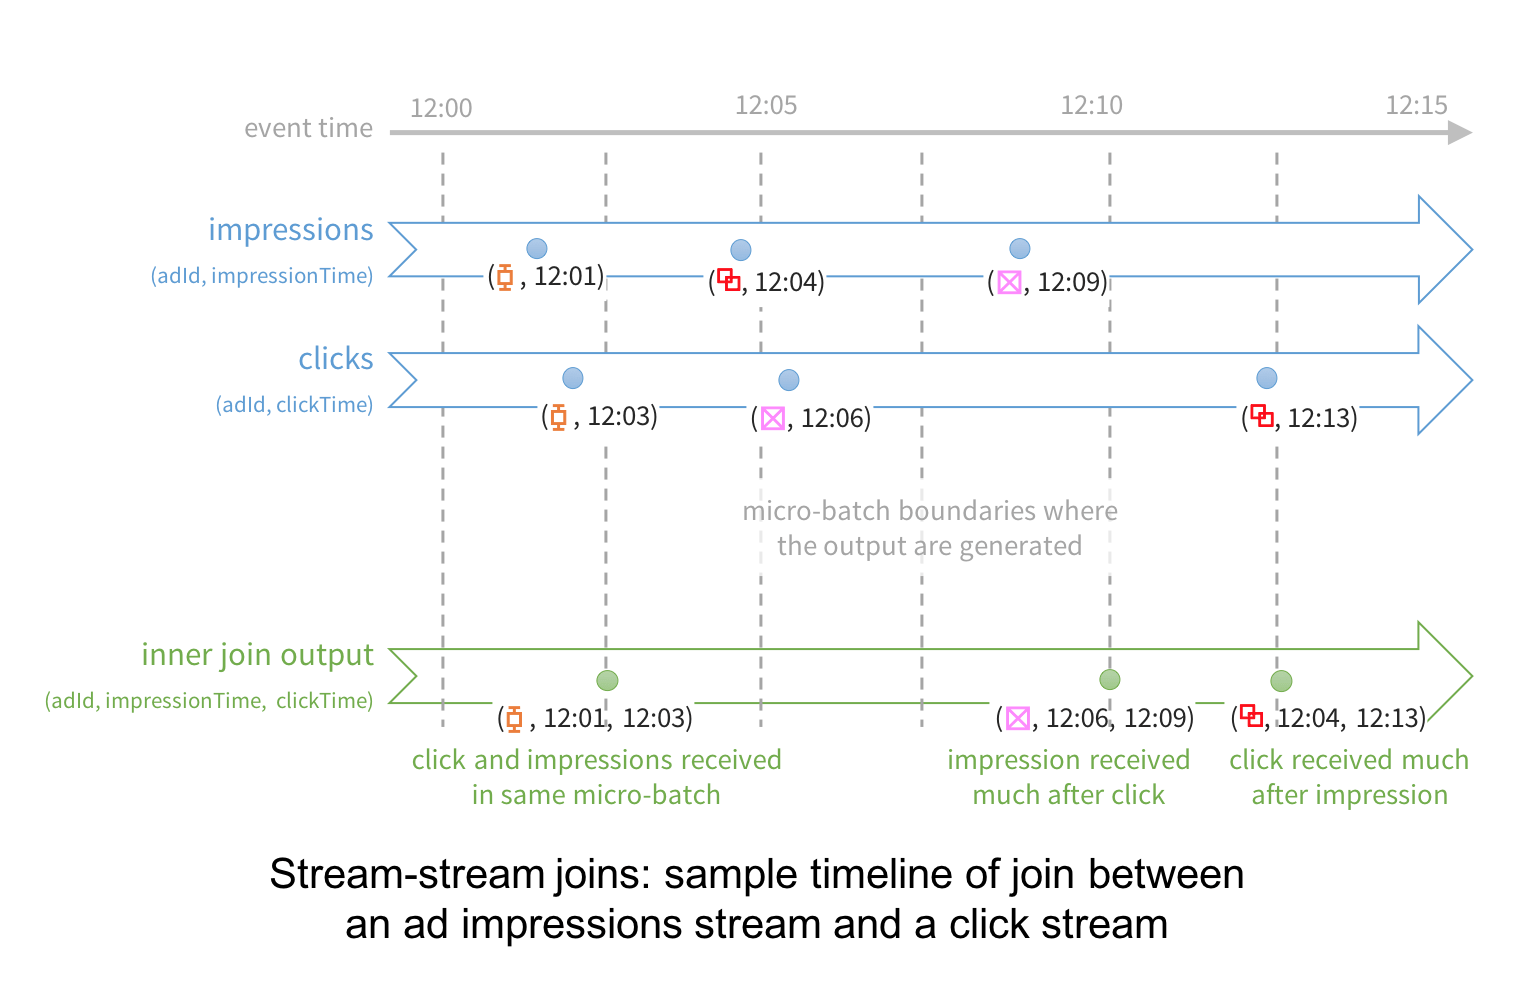

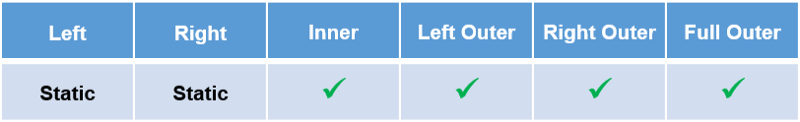

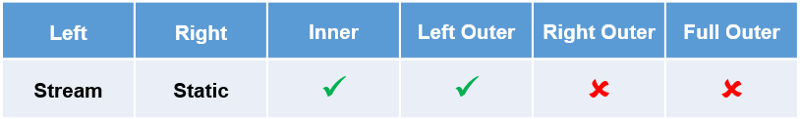

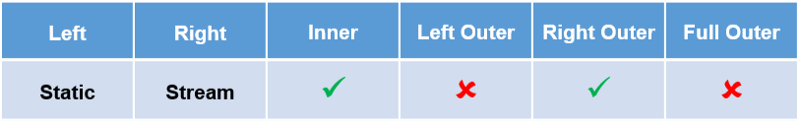

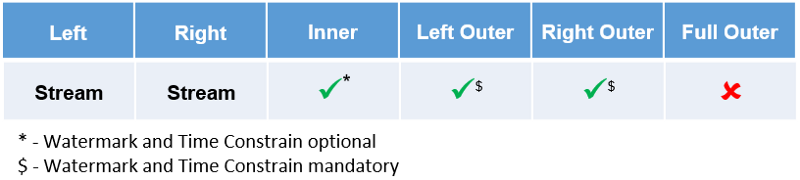

In [128]:
from pyspark.sql.functions import rand

spark.conf.set("spark.sql.shuffle.partitions", "1")

impressions = (
  spark
    .readStream.format("rate").option("rowsPerSecond", "5").option("numPartitions", "1").load()
    .selectExpr("value AS adId", "timestamp AS impressionTime")
)

clicks = (
  spark
  .readStream.format("rate").option("rowsPerSecond", "5").option("numPartitions", "1").load()
  .where((rand() * 100).cast("integer") < 10)      # 10 out of every 100 impressions result in a click
  .selectExpr("(value - 50) AS adId ", "timestamp AS clickTime")      # -50 so that a click with same id as impression is generated later (i.e. delayed data).
  .where("adId > 0")
)

def create_console_sink(df):
    return df \
        .writeStream \
        .outputMode("append") \
        .format("console") \
        .trigger(processingTime="3 seconds") \
        .option("truncate", "false") \
        .option("numRows", "20")

def create_parquet_sink(df, file_name):
    return df \
            .writeStream \
            .format("parquet") \
            .option("path", "{f}".format(f=file_name)) \
            .option("checkpointLocation", "chk/{f}".format(f=file_name)) \
            .trigger(processingTime="10 seconds")

def kill_all():
    streams = SparkSession.builder.getOrCreate().streams.active
    if streams:
        for s in streams:
            desc = s.lastProgress["sources"][0]["description"]
            s.stop()
            print("Stopped {s}".format(s=desc))

In [129]:
!hdfs dfs -rm -r impressions.parquet
!hdfs dfs -rm -r clicks.parquet
!hdfs dfs -rm -r inner.parquet
!hdfs dfs -rm -r chk

rm: `impressions.parquet': No such file or directory
rm: `clicks.parquet': No such file or directory
Deleted inner.parquet
Deleted chk


In [153]:
!hdfs dfs -du -s -h chk/*
# 6.2 K   6.2 K   chk/clicks.parquet
# 6.2 K   6.2 K   chk/impressions.parquet
# 38.7 K  38.7 K  chk/inner.parquet

6.2 K    6.2 K    chk/clicks.parquet
6.2 K    6.2 K    chk/impressions.parquet
101.5 K  101.5 K  chk/inner.parquet
24.2 K   24.2 K   chk/inner_watermark.parquet


In [131]:
s1 = create_parquet_sink(impressions, 'impressions.parquet')
s2 = create_parquet_sink(clicks, 'clicks.parquet')
s3 = create_parquet_sink(impressions.join(clicks, "adId"), 'inner.parquet')

In [132]:
import time

s1.start()
s2.start()
s3.start()

time.sleep(120)

In [133]:
kill_all()

Stopped RateStreamV2[rowsPerSecond=5, rampUpTimeSeconds=0, numPartitions=1
Stopped RateStreamV2[rowsPerSecond=5, rampUpTimeSeconds=0, numPartitions=1
Stopped RateStreamV2[rowsPerSecond=5, rampUpTimeSeconds=0, numPartitions=1


In [134]:
spark.read.parquet('impressions.parquet').sort('impressionTime').show(truncate=30)

+----+-----------------------+
|adId|         impressionTime|
+----+-----------------------+
|   0|2022-05-18 17:09:58.343|
|   1|2022-05-18 17:09:58.543|
|   2|2022-05-18 17:09:58.743|
|   3|2022-05-18 17:09:58.943|
|   4|2022-05-18 17:09:59.143|
|   5|2022-05-18 17:09:59.343|
|   6|2022-05-18 17:09:59.543|
|   7|2022-05-18 17:09:59.743|
|   8|2022-05-18 17:09:59.943|
|   9|2022-05-18 17:10:00.143|
|  10|2022-05-18 17:10:00.343|
|  11|2022-05-18 17:10:00.543|
|  12|2022-05-18 17:10:00.743|
|  13|2022-05-18 17:10:00.943|
|  14|2022-05-18 17:10:01.143|
|  15|2022-05-18 17:10:01.343|
|  16|2022-05-18 17:10:01.543|
|  17|2022-05-18 17:10:01.743|
|  18|2022-05-18 17:10:01.943|
|  19|2022-05-18 17:10:02.143|
+----+-----------------------+
only showing top 20 rows



In [136]:
spark.read.parquet('clicks.parquet').sort('clickTime').show(truncate=30)

+----+-----------------------+
|adId|              clickTime|
+----+-----------------------+
|   2|2022-05-18 17:10:09.253|
|   5|2022-05-18 17:10:09.853|
|   7|2022-05-18 17:10:10.253|
|  10|2022-05-18 17:10:10.853|
|  19|2022-05-18 17:10:12.653|
|  24|2022-05-18 17:10:13.653|
|  26|2022-05-18 17:10:14.053|
|  27|2022-05-18 17:10:14.253|
|  35|2022-05-18 17:10:15.853|
|  37|2022-05-18 17:10:16.253|
|  51|2022-05-18 17:10:19.053|
|  55|2022-05-18 17:10:19.853|
|  58|2022-05-18 17:10:20.453|
|  71|2022-05-18 17:10:23.053|
|  79|2022-05-18 17:10:24.653|
|  89|2022-05-18 17:10:26.653|
|  90|2022-05-18 17:10:26.853|
|  99|2022-05-18 17:10:28.653|
| 100|2022-05-18 17:10:28.853|
| 111|2022-05-18 17:10:31.053|
+----+-----------------------+
only showing top 20 rows



In [138]:
spark.read.parquet('inner.parquet').sort('impressionTime').show(100, truncate=30)

+----+-----------------------+-----------------------+
|adId|         impressionTime|              clickTime|
+----+-----------------------+-----------------------+
|   2|2022-05-18 17:09:59.762|2022-05-18 17:10:09.859|
|  22|2022-05-18 17:10:03.762|2022-05-18 17:10:13.859|
|  26|2022-05-18 17:10:04.562|2022-05-18 17:10:14.659|
|  32|2022-05-18 17:10:05.762|2022-05-18 17:10:15.859|
|  55|2022-05-18 17:10:10.362|2022-05-18 17:10:20.459|
|  62|2022-05-18 17:10:11.762|2022-05-18 17:10:21.859|
|  66|2022-05-18 17:10:12.562|2022-05-18 17:10:22.659|
|  74|2022-05-18 17:10:14.162|2022-05-18 17:10:24.259|
|  80|2022-05-18 17:10:15.362|2022-05-18 17:10:25.459|
| 104|2022-05-18 17:10:20.162|2022-05-18 17:10:30.259|
| 122|2022-05-18 17:10:23.762|2022-05-18 17:10:33.859|
| 133|2022-05-18 17:10:25.962|2022-05-18 17:10:36.059|
| 136|2022-05-18 17:10:26.562|2022-05-18 17:10:36.659|
| 139|2022-05-18 17:10:27.162|2022-05-18 17:10:37.259|
| 167|2022-05-18 17:10:32.762|2022-05-18 17:10:42.859|
| 169|2022

In [140]:
impressions = (
  spark
    .readStream.format("rate").option("rowsPerSecond", "1").option("numPartitions", "1").load()
    .selectExpr("value % 60 AS adId", "timestamp AS impressionTime")
)

clicks = (
  spark
  .readStream.format("rate").option("rowsPerSecond", "1").option("numPartitions", "1").load()
  .where((rand() * 100).cast("integer") < 50)
  .selectExpr("(value % 60) AS adId ", "timestamp AS clickTime")
  .where("adId > 0")
)

s3 = create_parquet_sink(impressions.join(clicks, "adId"), 'inner.parquet')

In [141]:
s3.start()

In [143]:
time.sleep(60)
spark.read.parquet('inner.parquet').sort('impressionTime').show(100, truncate=30)

+----+-----------------------+-----------------------+
|adId|         impressionTime|              clickTime|
+----+-----------------------+-----------------------+
|   1|2022-05-18 17:09:59.562|2022-05-18 17:16:00.459|
|   2|2022-05-18 17:09:59.762|2022-05-18 17:10:09.859|
|   2|2022-05-18 17:09:59.762|2022-05-18 17:12:01.459|
|   2|2022-05-18 17:09:59.762|2022-05-18 17:13:01.459|
|   2|2022-05-18 17:09:59.762|2022-05-18 17:15:01.459|
|   2|2022-05-18 17:09:59.762|2022-05-18 17:17:01.459|
|   2|2022-05-18 17:09:59.762|2022-05-18 17:16:01.459|
|   3|2022-05-18 17:09:59.962|2022-05-18 17:14:02.459|
|   3|2022-05-18 17:09:59.962|2022-05-18 17:15:02.459|
|   4|2022-05-18 17:10:00.162|2022-05-18 17:14:03.459|
|   4|2022-05-18 17:10:00.162|2022-05-18 17:12:03.459|
|   4|2022-05-18 17:10:00.162|2022-05-18 17:16:03.459|
|   4|2022-05-18 17:10:00.162|2022-05-18 17:17:03.459|
|   5|2022-05-18 17:10:00.362|2022-05-18 17:14:04.459|
|   5|2022-05-18 17:10:00.362|2022-05-18 17:15:04.459|
|   6|2022

In [152]:
kill_all()

In [148]:
from pyspark.sql.functions import expr

# Define watermarks
impressionsWithWatermark = impressions \
  .selectExpr("adId AS impressionAdId", "impressionTime") \
  .withWatermark("impressionTime", "10 seconds ")
clicksWithWatermark = clicks \
  .selectExpr("adId AS clickAdId", "clickTime") \
  .withWatermark("clickTime", "20 seconds")        # max 20 seconds late


# Inner join with time range conditions
s5 = create_parquet_sink(
  impressionsWithWatermark.join(
    clicksWithWatermark,
    expr(""" 
      clickAdId = impressionAdId AND 
      clickTime >= impressionTime AND 
      clickTime <= impressionTime + interval 1 minutes    
      """
    )
  ), 'inner_watermark.parquet'
)

In [149]:
s5.start()

In [150]:
time.sleep(60)
spark.read.parquet('inner_watermark.parquet').sort('impressionTime').show(100, truncate=30)

+--------------+-----------------------+---------+-----------------------+
|impressionAdId|         impressionTime|clickAdId|              clickTime|
+--------------+-----------------------+---------+-----------------------+
|             1|2022-05-18 17:19:52.916|        1|2022-05-18 17:19:52.992|
|             5|2022-05-18 17:19:56.916|        5|2022-05-18 17:19:56.992|
|             6|2022-05-18 17:19:57.916|        6|2022-05-18 17:19:57.992|
|             7|2022-05-18 17:19:58.916|        7|2022-05-18 17:19:58.992|
|             8|2022-05-18 17:19:59.916|        8|2022-05-18 17:19:59.992|
|            10|2022-05-18 17:20:01.916|       10|2022-05-18 17:20:01.992|
|            11|2022-05-18 17:20:02.916|       11|2022-05-18 17:20:02.992|
|            12|2022-05-18 17:20:03.916|       12|2022-05-18 17:20:03.992|
|            15|2022-05-18 17:20:06.916|       15|2022-05-18 17:20:06.992|
|            17|2022-05-18 17:20:08.916|       17|2022-05-18 17:20:08.992|
|            21|2022-05-1